In [1]:
import torch
import torch.nn as nn
import torchtext.data as ttd
import spacy
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import random
import ast
from others.config import *

hyperparameters = config['hyperparameters']
spacy = spacy.load('en')
gpu = ('cuda:0')

In [2]:
TEXT = ttd.Field(
    sequential=True
    ,batch_first=True
    ,lower=True
    ,tokenize='spacy'
    ,pad_first=True
    )

LABEL = ttd.Field(
    sequential=False
    ,use_vocab=False
    ,is_target=True
    )

In [3]:
dataset = ttd.TabularDataset(
    path='dataset/train_dataset.csv',
    format='csv',
    skip_header=True,
    fields=[('data', TEXT), ('label', LABEL)]
    )

In [4]:
ex = dataset.examples[0]
print(ex.data)
print(ex.label)

['@menyrbie', '@phil_gahan', '@chrisitv', 'https://t.co/ifz9fan2', 'pa', 'and', 'https://t.co/xx6ghgfzcc', 'and', 'https://t.co/i2nlzdxno8']
2


In [5]:
train_dataset, validation_dataset = dataset.split(split_ratio=0.7, random_state = random.seed(14))

In [6]:
TEXT.build_vocab(train_dataset)
vocab = TEXT.vocab
print('len vocab: {}'.format(len(vocab)))
# vocab.stoi

len vocab: 66116


In [7]:
train_iter, validation_iter = ttd.BucketIterator.splits(
    (train_dataset, validation_dataset), 
    sort_key=lambda x: len(x.data),
    batch_sizes=(ast.literal_eval(hyperparameters['batch_sizes'])[0], ast.literal_eval(hyperparameters['batch_sizes'])[1]), 
    device=gpu
    )

In [8]:
for inputs, labels in validation_iter:
    print('inputs: {}, shape: {}'.format(inputs, inputs.shape))
    print('lables: {}, shape: {}'.format(labels, labels.shape))
    break

inputs: tensor([[   47,   478,    20,  ...,     7,    70,    61],
        [   47,  1522,   325,  ...,    22,   863,     0],
        [ 1881,   795,   639,  ...,    59,   153,    61],
        ...,
        [    1,     1,     1,  ...,     1,   116, 29005],
        [    1,     1,     1,  ...,     1,  4645,    14],
        [    1,     1,     1,  ...,     1,   991,   218]], device='cuda:0'), shape: torch.Size([128, 8])
lables: tensor([2, 2, 3, 2, 1, 1, 1, 1, 1, 0, 3, 2, 2, 3, 2, 2, 2, 3, 2, 3, 1, 3, 3, 1,
        2, 1, 3, 2, 0, 2, 1, 1, 3, 1, 2, 2, 2, 3, 0, 1, 3, 1, 2, 3, 2, 1, 2, 2,
        2, 2, 2, 2, 1, 2, 3, 1, 2, 2, 2, 3, 3, 2, 2, 3, 2, 1, 2, 2, 3, 0, 2, 2,
        2, 3, 3, 2, 1, 3, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2, 2, 1, 2, 2, 3, 2, 2,
        2, 1, 2, 1, 1, 2, 3, 4, 1, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2,
        2, 2, 2, 2, 2, 0, 2, 2], device='cuda:0'), shape: torch.Size([128])


In [9]:
class BiLSTM(nn.Module):
    def __init__(self, n_vocabs, embed_dims, n_lstm_units, n_lstm_layers, n_output_classes):
        super(BiLSTM, self).__init__()
        self.v = n_vocabs
        self.e = embed_dims
        self.u = n_lstm_units
        self.l = n_lstm_layers
        self.o = n_output_classes

        self.embed = nn.Embedding(
            self.v,
            self.e
            )
        self.bilstm = nn.LSTM(
            input_size = self.e,
            hidden_size = self.u,
            num_layers = self.l,
            batch_first = True,
            bidirectional = True,
            dropout = 0.5
        )
        self.linear = nn.Linear(
            self.u * 2,
            self.o
        )

    def forward(self, X):
        h0 = torch.zeros(self.l * 2, X.size(0), self.u).to(gpu)
        c0 = torch.zeros(self.l * 2, X.size(0), self.u).to(gpu)

        out = self.embed(X)
        # NxTxh, lxNxh
        out, _ = self.bilstm(out, (h0, c0))
        # GMP
        out, _ = torch.max(out, 1)
        out = self.linear(out)
        iout = torch.max(out, 1)[1]

        return iout, out

In [10]:
checkpoint = torch.load('checkpoint/corona_tweets_lowest_val_loss_epoch_2.pth')

In [11]:
model = BiLSTM(
    len(vocab),
    ast.literal_eval(hyperparameters['embed_dims']), 
    ast.literal_eval(hyperparameters['num_lstm_units']), 
    ast.literal_eval(hyperparameters['num_lstm_layers']), 
    ast.literal_eval(hyperparameters['num_output_classes'])
    ).to(gpu)
model.load_state_dict(checkpoint['state_dict'])
model

BiLSTM(
  (embed): Embedding(66116, 512)
  (bilstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (linear): Linear(in_features=1024, out_features=5, bias=True)
)

In [12]:
test_preds = torch.tensor([])
for inputs, labels in validation_iter:
    model.eval()
    with torch.no_grad():
        preds = model(inputs)
        test_preds = torch.cat(
            (test_preds, preds[0].cpu())
            )

test_act_labels =  torch.tensor([])
for inputs, labels in validation_iter:
    test_act_labels = torch.cat(
            (test_act_labels, labels.cpu())
            )

# print(test_preds)
# print(test_act_labels)

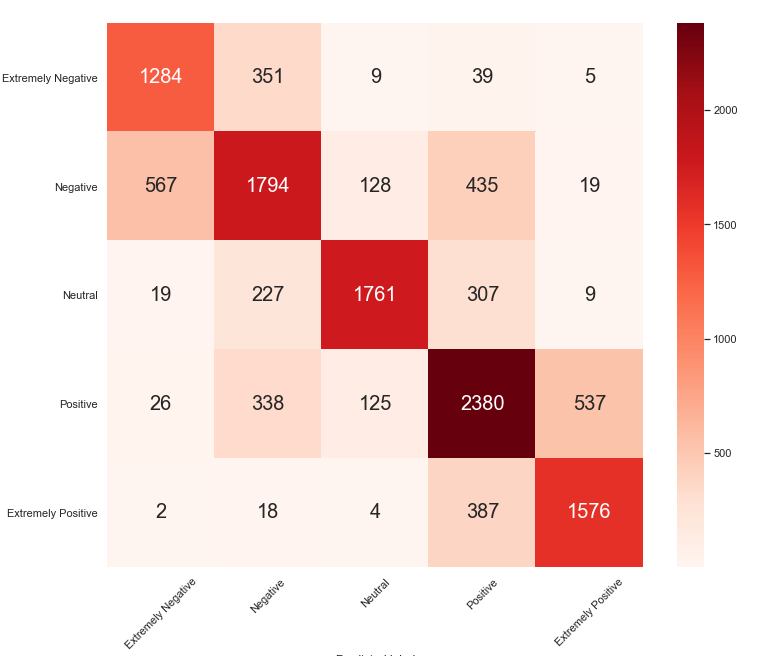

In [13]:
# confusion matrix
cnf_matrix = confusion_matrix(test_act_labels, test_preds)

# plot confusion matrix with seaborn
plt.figure(figsize=(12,10))

x_axis_labels = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']
y_axis_labels = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']

sns.set(font_scale=1)#for label size
sns.heatmap(cnf_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, annot_kws={"size": 20} , cmap="Reds", fmt='g')

plt.yticks(rotation=360)
plt.xticks(rotation=45)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('graphs/cnf_lstm.png', dpi = 100)

In [14]:
report = classification_report(test_act_labels, test_preds)
print(report)

              precision    recall  f1-score   support

         0.0       0.68      0.76      0.72      1688
         1.0       0.66      0.61      0.63      2943
         2.0       0.87      0.76      0.81      2323
         3.0       0.67      0.70      0.68      3406
         4.0       0.73      0.79      0.76      1987

    accuracy                           0.71     12347
   macro avg       0.72      0.72      0.72     12347
weighted avg       0.72      0.71      0.71     12347



In [17]:
# a single prediction
def inference(sentence):
    tokenized = [i.text for i in spacy.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[i] for i in tokenized]
    sample = torch.tensor(indexed).to(gpu)
    sample =  sample.unsqueeze(0)
    model.eval()
    with torch.no_grad():
        predictions = model(sample)
        prob = nn.functional.softmax(predictions[1], 1)
        max_prob, idx = torch.max(prob, 1)
        label = "Extremely Negative" if idx == 0 else ("Negative" if idx == 1 else ("Neutral" if idx == 2 else ("Positive" if idx == 3 else "Extremely Positive")))
    return print('Prediction : {} Sentiment\nThe Sentiment Probability is:\nExtremely Negative : {:.2f}%\nNegative : {:.2f}%\nNeutral : {:.2f}%\nPositive : {:.2f}%\nExtremely Positive : {:.2f}%'.format(label, prob[0][0].item()*100, prob[0][1].item()*100, prob[0][2].item()*100, prob[0][3].item()*100, prob[0][4].item()*100))

In [18]:
text = inference("My elderly in-laws are staying at home & I'm doing their shopping online. The old man married his TV a long time ago, so it's not a problem for him. The old dear just needs the phone & she's happy. Protect your loved ones, #Coronavi")

Prediction : Extremely Positive Sentiment
The Sentiment Probability is:
Extremely Negative : 0.00%
Negative : 0.00%
Neutral : 0.01%
Positive : 2.55%
Extremely Positive : 97.45%
